# DNN, BDT and RF in TopFC analysis
Author: Meisam Ghasemi Bostanabad

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [332]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_charm':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_charm.root'
    }

'''
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_up':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_up.root'}
    }
'''

upfile = {}
params = {}
df = {}

# choose which vars to use (multi dimensional)
#VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass', 'weight'] # choose which vars to use (2d)
VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass'] # choose which vars to use (2d)

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 

## Data exploration

In [333]:
# reduce signal DF size to have resonable Sig/Bkg ratio
df['signal_charm'] = df['signal_charm'][:1500]

In [334]:
print(len(df['signal_charm']))
#print(len(df['signal_charm'][df['isSignal']==1]))

1500


In [335]:
print(set(df['ttbar']['isSignal']))
print(set(df['ttbar']['jetNo']))
#print(set(df['ttbar']['weight']))
#print(set(df['signal_charm']['weight']))

{0.0}
{2, 3, 4, 5, 6}


In [336]:
# number of entries in the backgrounds and signals
tot_bkg = 0
for treename in filename.keys():
    if not 'signal' in treename: tot_bkg += df[treename].shape[0]
    print(treename, ":", df[treename].shape)

print("signal/tot bkg:", round((df['signal_charm'].shape[0]/ tot_bkg),1))
#print("Null entries:", df['signal_charm'].isna().sum())

ttbar : (381, 7)
WZ : (936, 7)
ZZ : (76, 7)
signal_charm : (1500, 7)
signal/tot bkg: 1.1


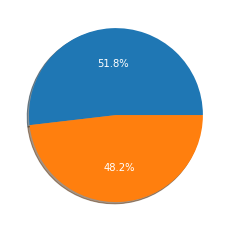

In [337]:
counts_signal = df['signal_charm'].shape[0]
counts_background = tot_bkg
plt.pie([counts_signal, counts_background], shadow=True, labels=['Signal ','Background'], textprops={'color':"w"}, autopct='%1.1f%%');

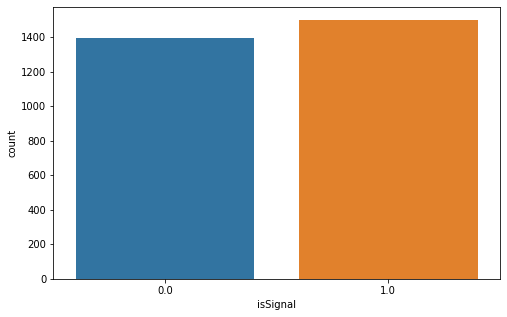

In [338]:
# show the number of total signals and backgrounds
df_all = pd.concat([df[treename] for treename in filename.keys()])
plt.figure(figsize=(8,5))
sns.countplot(x='isSignal',data=df_all);

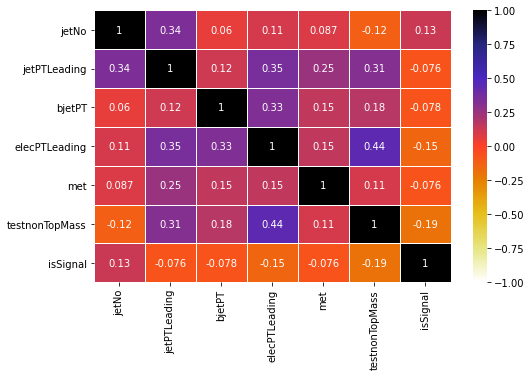

In [339]:
# show the correlation between features
plt.figure(figsize=(8,5))
#sns.heatmap(df_all.corr(), annot=True, linewidth=.5)
sns.heatmap(df_all.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r);

In [340]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2893 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jetNo           2893 non-null   int32  
 1   jetPTLeading    2893 non-null   float64
 2   bjetPT          2893 non-null   float64
 3   elecPTLeading   2893 non-null   float64
 4   met             2893 non-null   float64
 5   testnonTopMass  2893 non-null   float64
 6   isSignal        2893 non-null   float64
dtypes: float64(6), int32(1)
memory usage: 234.1 KB


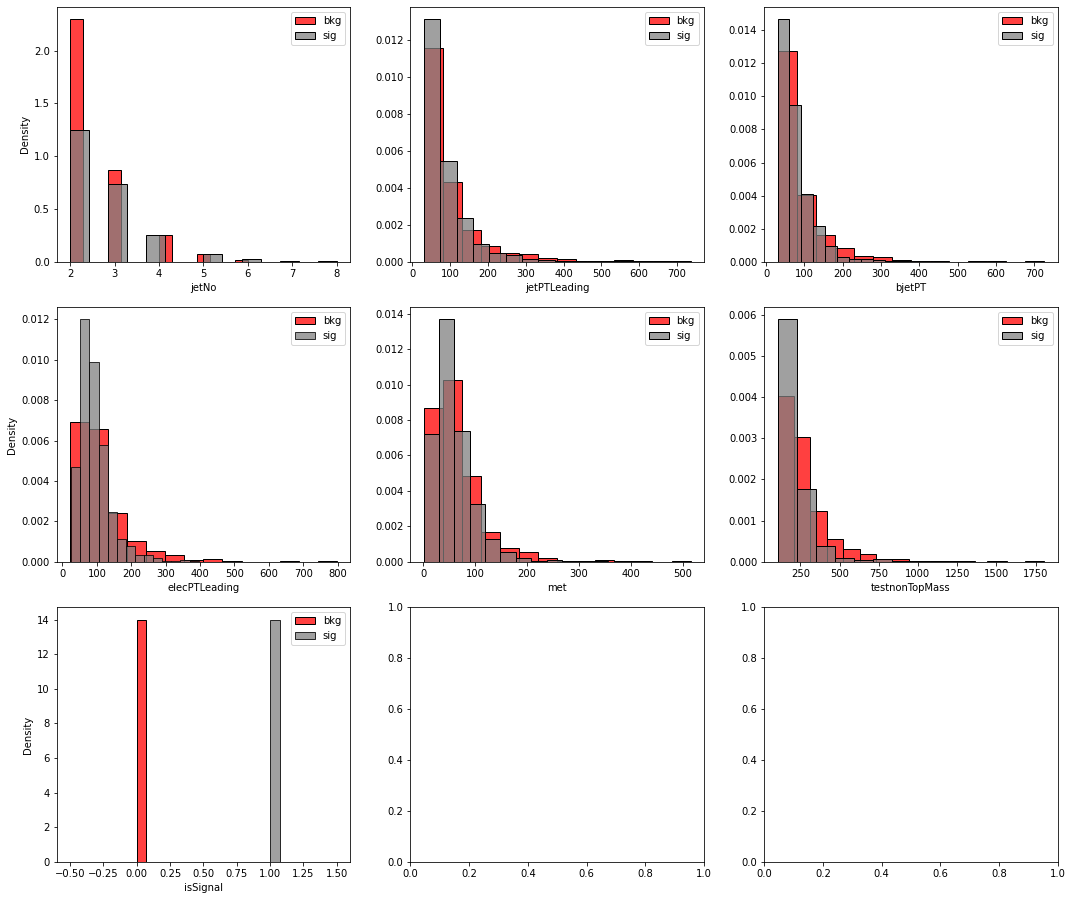

In [341]:
# Function to plot distributions of the float features
import math 
def hist(df1, df2, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        #sns.histplot(data = df, x = cols[i], bins = bins, hue = 'isSignal', palette = ['grey', 'red'], ax = ax[i // ncols, i % ncols], stat="probability")
        sns.histplot(data = df1, x = cols[i], bins = bins, color = 'red',
                      ax = ax[i // ncols, i % ncols], stat="density", label='bkg')
        sns.histplot(data = df2, x = cols[i], bins = bins, color = 'grey',
                      ax = ax[i // ncols, i % ncols], stat="density", label='sig')       
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        ax[i // ncols, i % ncols].legend()
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
        
    plt.tight_layout()
    plt.show()

# Distributions of the float features
hist(df_all[df_all['isSignal']==0].replace(-999, np.nan),
     df_all[df_all['isSignal']==1].replace(-999, np.nan),
     #list(df_all.columns[df_all.dtypes == 'float64']),
     list(df_all.columns),
     bins = math.floor(len(df_all)**(1/3)),
     ncols = 3)

## Define the models

## NN from Tensorflow
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 
We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset).
We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best `val_loss`.

In [342]:
df_all = pd.concat([df[treename] for treename in filename.keys()])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input') 
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('TopFC_dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6)]               0         
                                                                 
 output (Dense)              (None, 1)                 7         
                                                                 
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


## Run training 
Here, we run the training.

In [343]:
# Train classifier
import time
start = time.time() # time at start of whole processing

history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=512, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Epoch 1/1000
5/5 [==============================] - 1s 37ms/step - loss: 0.6910 - accuracy: 0.5328 - val_loss: 0.6893 - val_accuracy: 0.5596
Epoch 2/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6895 - accuracy: 0.5506 - val_loss: 0.6878 - val_accuracy: 0.5579
Epoch 3/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6882 - accuracy: 0.5510 - val_loss: 0.6863 - val_accuracy: 0.5665
Epoch 4/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6868 - accuracy: 0.5622 - val_loss: 0.6849 - val_accuracy: 0.5699
Epoch 5/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6856 - accuracy: 0.5678 - val_loss: 0.6835 - val_accuracy: 0.5769
Epoch 6/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6844 - accuracy: 0.5700 - val_loss: 0.6822 - val_accuracy: 0.5872
Epoch 7/1000
5/5 [==============================] - 0s 9ms/step - loss: 0.6832 - accuracy: 0.5730 - val_loss: 0.6810 - val_accuracy: 0.5889
Epoch 8/1000
5/5 [

## Plot performance and reports
Here, we plot the history of the training and the performance in a ROC curve

73/73 [==============================] - 0s 690us/step


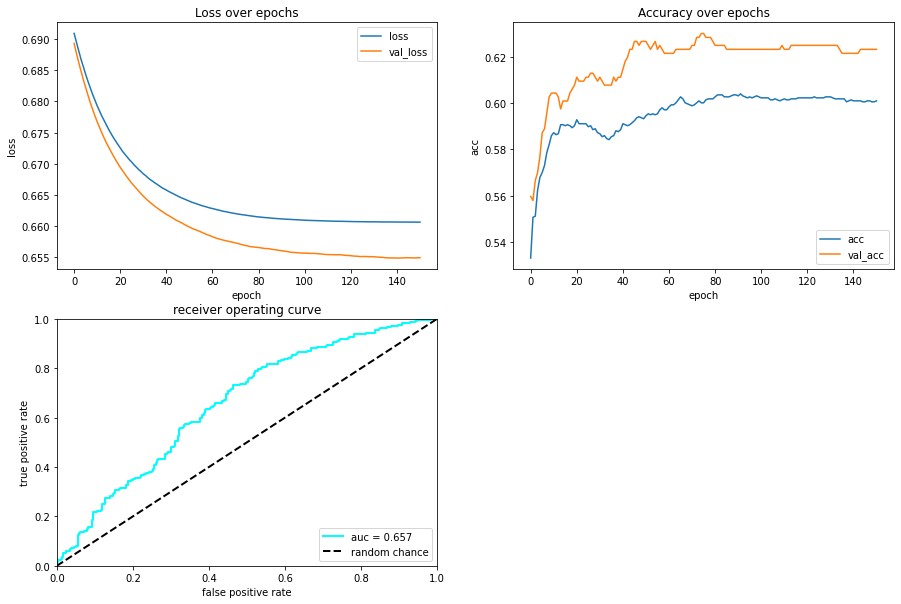

91/91 [==============================] - 0s 699us/step
0.6234887737478411
0.601123595505618
Classification report for the test set
              precision    recall  f1-score   support

  background       0.67      0.49      0.57       293
      signal       0.59      0.76      0.66       286

    accuracy                           0.62       579
   macro avg       0.63      0.63      0.62       579
weighted avg       0.63      0.62      0.62       579

Classification report for the total set
              precision    recall  f1-score   support

  background       0.63      0.45      0.52      1393
      signal       0.59      0.75      0.66      1500

    accuracy                           0.61      2893
   macro avg       0.61      0.60      0.59      2893
weighted avg       0.61      0.61      0.60      2893

91/91 [==============================] - 0s 704us/step


In [344]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score

%matplotlib inline
def loss_accuracy_plotter(history):
    # plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.legend(loc="upper right")
    ax.set_title('Loss over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # plot accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    ax.plot(history.history['accuracy'], label='acc')
    ax.plot(history.history['val_accuracy'], label='val_acc')
    ax.legend(loc="lower right")
    ax.set_title('Accuracy over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Plot ROC
    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.show()

loss_accuracy_plotter(history)


from sklearn.metrics import accuracy_score, classification_report

Y_pred_test = model.predict(X_test)
Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0])
Y_pred_train = model.predict(X_train_val)
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])
Y_pred_tot = model.predict(scaler.transform(X)).round()
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])

# accuracy score
print(accuracy_score(Y_test.round(), Y_pred_test.round()))
print(accuracy_score(Y_train_val.round(), Y_pred_train.round()))

# classification report for the test and total sets
print("Classification report for the test set")
print(classification_report(Y_test.round(), Y_pred_test.round(), target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y.round(), Y_pred_tot.round(), target_names=['background', 'signal']))

fpr_nn, tpr_nn, thresholds_nn = roc_curve(Y_test, Y_pred_test) # get FPRs, TPRs and thresholds for neural network

df_all['dense_NN'] = model.predict(scaler.transform(X)).round() # add prediction to array
#df_all['dense_NN'] = model.predict_proba(X)[:, 1]
#print (df_all.iloc[:5])

## NN from Sklearn


In [345]:
from sklearn.neural_network import MLPClassifier

import time
start = time.time() # time at start of whole processing

hidden_layer_sizes = [len(VARS)] # 1 hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer_sizes), # define parameters for our multi-layer-perceptron
                    max_iter=500 ) # max number of iterations
mlp.fit(X_train_val,Y_train_val)

y_predict = mlp.predict_proba(X_test)[:,1].round()
print("Classification report for the test set")
print(classification_report(Y_test.round(), y_predict.round(), target_names=['background', 'signal']))

ytot_predict = mlp.predict_proba(X)[:,1].round()
print("Classification report for the total set")
print(classification_report(Y.round(), ytot_predict.round(), target_names=['background', 'signal']))

fpr_nn_sk, tpr_nn_sk, thresholds_nn_sk = roc_curve(Y_test.round(), y_predict.round()) # get FPRs, TPRs and thresholds for neural network


#df_all['sklearn_dense_NN'] = mlp.predict(X) # add prediction to array
df_all['sklearn_dense_NN'] = mlp.predict(scaler.transform(X)).round() # add prediction to array

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Classification report for the test set
              precision    recall  f1-score   support

  background       0.64      0.62      0.63       293
      signal       0.62      0.65      0.64       286

    accuracy                           0.63       579
   macro avg       0.63      0.63      0.63       579
weighted avg       0.63      0.63      0.63       579

Classification report for the total set
              precision    recall  f1-score   support

  background       0.48      1.00      0.65      1393
      signal       0.50      0.00      0.01      1500

    accuracy                           0.48      2893
   macro avg       0.49      0.50      0.33      2893
weighted avg       0.49      0.48      0.32      2893

Time taken: 1.1s


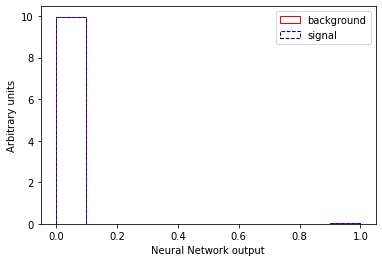

In [346]:
# we first plot the Neural Network output
signal_decisions = mlp.predict_proba(X[Y>0.5])[:, 1] # get probabilities on signal
background_decisions = mlp.predict_proba(X[Y<0.5])[:, 1] # get probabilities on background

plt.hist(background_decisions, color='red', label='background', 
         histtype='step', # lineplot that's unfilled
         density=True ) # normalize to form a probability density
plt.hist(signal_decisions, color='blue', label='signal', 
         histtype='step', # lineplot that's unfilled
         density=True, # normalize to form a probability density
         linestyle='--' ) # dashed line
plt.xlabel('Neural Network output') # add x-axis label
plt.ylabel('Arbitrary units') # add y-axis label
plt.legend() # add legend

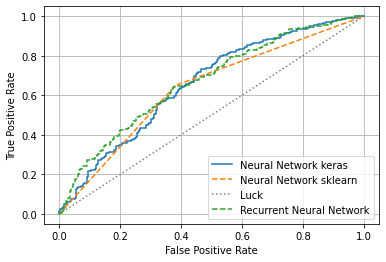

In [347]:
plt.plot(fpr_nn, tpr_nn, label='Neural Network keras') # plot random forest ROC
plt.plot(fpr_nn_sk, tpr_nn_sk, linestyle='dashed', label='Neural Network sklearn') # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.plot(fpr_rnn, tpr_rnn, linestyle='dashed', label='Recurrent Neural Network') # plot RNN ROC
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

## Save the predictions

In [348]:
df_all[df_all['isSignal']==1].head()
df_all[df_all['dense_NN']==1].head()
df_all[df_all['sklearn_dense_NN']==1].head()

,jetNo,jetPTLeading,bjetPT,elecPTLeading,met,testnonTopMass,isSignal,dense_NN,sklearn_dense_NN
entry,,,,,,,,,
1,3,67.292442,32.879086,87.680885,32.989780,206.483257,0.0,1.0,1.0
2,5,216.352081,48.157005,33.488476,145.810104,176.785610,0.0,1.0,1.0
3,4,347.645050,71.226440,65.760910,186.715225,172.066595,0.0,1.0,1.0
4,3,64.248962,80.717056,36.373375,61.273373,159.428297,0.0,1.0,1.0
5,4,53.700779,94.250420,65.454498,81.860435,170.679508,0.0,1.0,1.0


# Recurrent Neural Network (LSTM)

In [349]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate,GRU,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import FixedLenFeature
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, normalize

import tensorflow as tf


X_train_LSTM = np.reshape(X_train_val, (X_train_val.shape[0],X_train_val.shape[1],1))    #(225000, 30, 1)
X_test_LSTM = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))        #(25000, 30, 1)

def build_Lstm_model(train_x,train_y,test_x,test_y):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_model = LSTM(units=60, return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_model = LSTM(units=60,recurrent_dropout=0.1)(rnn_1st_model)
    dense_layer = Dense(128)(rnn_2nd_model)
    drop_out = Dropout(0.2)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_LSTM.h5', monitor='val_loss', save_best_only=True)]
    model.summary()

    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),
                        tf.keras.losses.MeanSquaredLogarithmicError()],
                        metrics=['accuracy'], optimizer="adam")
    history = model.fit(train_x, train_y, 
          epochs = 100, 
          batch_size = 128, 
          validation_data=(test_x,  test_y), 
          callbacks=callbacks)
    return history,model
history_LSTM,Lstm_model = build_Lstm_model(X_train_LSTM,Y_train_val,X_test_LSTM,Y_test)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 6, 60)             14880     
                                                                 
 lstm_9 (LSTM)               (None, 60)                29040     
                                                                 
 dense_4 (Dense)             (None, 128)               7808      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 class (Dense)               (None, 1)                 129       
                                                                 
Total params: 51,857
Trainable params: 51,857
Non-trainabl

73/73 [==============================] - 0s 667us/step


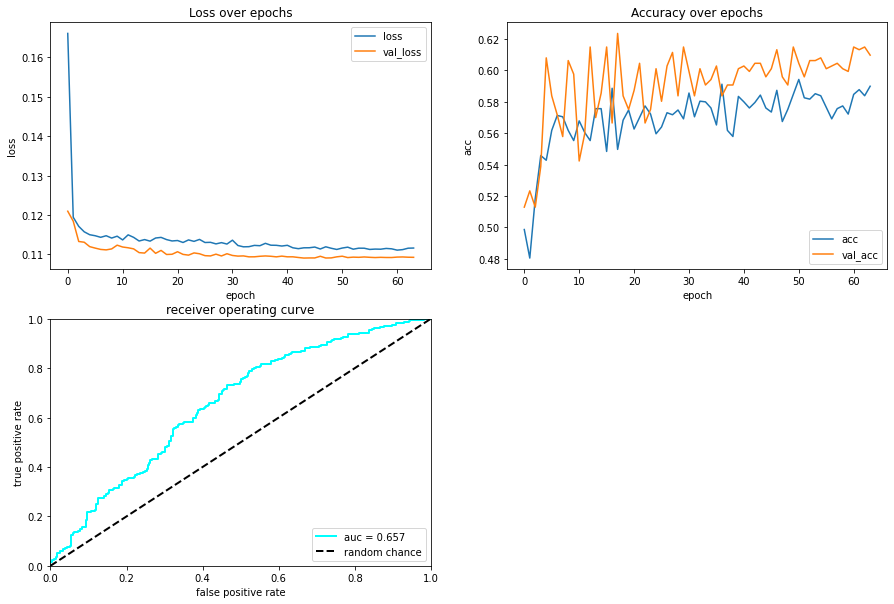

In [350]:
loss_accuracy_plotter(history_LSTM)

In [351]:
Y_pred_test = Lstm_model.predict(X_test)
Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0])
Y_pred_train = Lstm_model.predict(X_train_val)
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])
Y_pred_tot = Lstm_model.predict(scaler.transform(X)).round()
Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])

# accuracy score
print(accuracy_score(Y_test.round(), Y_pred_test.round()))
print(accuracy_score(Y_train_val.round(), Y_pred_train.round()))

# classification report for the test and total sets
print("Classification report for the test set")
print(classification_report(Y_test.round(), Y_pred_test.round(), target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y.round(), Y_pred_tot.round(), target_names=['background', 'signal']))

fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(Y_test, Y_pred_test) # get FPRs, TPRs and thresholds for neural network

df_all['dense_RNN'] = Lstm_model.predict(scaler.transform(X)).round() # add prediction to array

91/91 [==============================] - 0s 4ms/step
0.6096718480138169
0.583837510803803
Classification report for the test set
              precision    recall  f1-score   support

  background       0.58      0.84      0.68       293
      signal       0.69      0.38      0.49       286

    accuracy                           0.61       579
   macro avg       0.64      0.61      0.59       579
weighted avg       0.64      0.61      0.59       579

Classification report for the total set
              precision    recall  f1-score   support

  background       0.55      0.81      0.65      1393
      signal       0.68      0.38      0.49      1500

    accuracy                           0.59      2893
   macro avg       0.62      0.60      0.57      2893
weighted avg       0.62      0.59      0.57      2893

91/91 [==============================] - 0s 2ms/step


# Boosted Decision Tree

In [372]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train_val, Y_train_val)
y_pred_BDT = dtree.predict(X_test)

print("Classification report for the test set")
print(accuracy_score(Y_test,y_pred_BDT))
print("Classification report for the total set")
print(classification_report(Y_test.round(), y_pred_BDT.round(), target_names=['background', 'signal']))

fpr_bdt_old, tpr_bdt_old, thresholds_bdt_old = roc_curve(Y_test, y_pred_BDT)

df_all['dense_BDT_old'] = dtree.predict(scaler.transform(X)) # add prediction to array

Classification report for the test set
0.5682210708117443
Classification report for the total set
              precision    recall  f1-score   support

  background       0.58      0.55      0.56       293
      signal       0.56      0.58      0.57       286

    accuracy                           0.57       579
   macro avg       0.57      0.57      0.57       579
weighted avg       0.57      0.57      0.57       579



In [353]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=2) # maximum depth of the tree
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME', # SAMME discrete boosting algorithm
                        n_estimators=12, # max number of estimators at which boosting is terminated
                        learning_rate=0.5) # shrinks the contribution of each classifier by learning_rate

start = time.time() # time at start of BDT fit
bdt.fit(X_train_val, Y_train_val) # fit BDT to training set
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)

y_pred_BDT = bdt.predict(X_test)
print(accuracy_score(Y_test,y_pred_BDT))
print("Classification report for the test set")
print(classification_report(Y_test, y_pred_BDT, target_names=['background', 'signal']))

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(Y_test, y_pred_BDT)

df_all['dense_BDT'] = bdt.predict(scaler.transform(X)) # add prediction to array

Time taken to fit BDT: 0.1s
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=12)
0.6183074265975821
Classification report for the test set
              precision    recall  f1-score   support

  background       0.67      0.49      0.57       293
      signal       0.59      0.74      0.66       286

    accuracy                           0.62       579
   macro avg       0.63      0.62      0.61       579
weighted avg       0.63      0.62      0.61       579



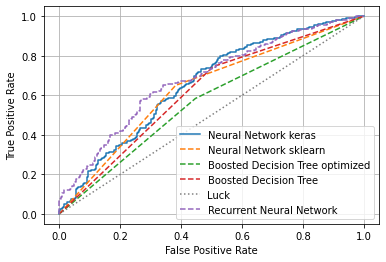

In [373]:
plt.fi
plt.plot(fpr_nn, tpr_nn, label='Neural Network keras') # plot random forest ROC
plt.plot(fpr_nn_sk, tpr_nn_sk, linestyle='dashed', label='Neural Network sklearn') # plot neural network ROC
plt.plot(fpr_bdt_old, tpr_bdt_old, linestyle='dashed', label='Boosted Decision Tree optimized') # plot neural network ROC
plt.plot(fpr_bdt, tpr_bdt, linestyle='dashed', label='Boosted Decision Tree') # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.plot(fpr_rnn, tpr_rnn, linestyle='dashed', label='Recurrent Neural Network') # plot RNN ROC
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

# Random Forest

In [407]:
# 8. Random Forest classifier for prediction and evaluate the model

from sklearn.ensemble import RandomForestClassifier

# the parameters for initializing are called hyperprameters
RF_clf = RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420) # initialise your random forest classifier
RF_clf.fit(X_train_val, Y_train_val) # fit to the training data
y_pred_RF = RF_clf.predict(X_test) # make predictions on the test data

# for my own curiosity
y_pred_RF_train = RF_clf.predict(X_train_val)
y_pred_RF_tot = RF_clf.predict(scaler.transform(X))


# See how well the classifier does, Acc = correct data / tot data
# The accuracy score is defined as the ratio of correctly identified data points to all data points.
print("Test accuracy:", accuracy_score(Y_test, y_pred_RF))
print("Train accuracy", accuracy_score(Y_train_val, y_pred_RF_train))
print("Total accuracy", accuracy_score(Y, y_pred_RF_tot))

print("Classification report for the test set")
print(classification_report(Y_test.round(), y_pred_RF.round(), target_names=['background', 'signal']))
print("Classification report for the train set")
print(classification_report(Y_train_val.round(), y_pred_RF_train.round(), target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y.round(), y_pred_RF_tot.round(), target_names=['background', 'signal']))

fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_RF)

df_all['dense_RF'] = RF_clf.predict(scaler.transform(X)) # add prediction to array

Test accuracy: 0.6528497409326425
Train accuracy 0.7925669835782195
Total accuracy 0.7646042170756999
Classification report for the test set
              precision    recall  f1-score   support

  background       0.68      0.60      0.64       293
      signal       0.63      0.70      0.67       286

    accuracy                           0.65       579
   macro avg       0.65      0.65      0.65       579
weighted avg       0.66      0.65      0.65       579

Classification report for the train set
              precision    recall  f1-score   support

  background       0.84      0.69      0.76      1100
      signal       0.76      0.88      0.82      1214

    accuracy                           0.79      2314
   macro avg       0.80      0.79      0.79      2314
weighted avg       0.80      0.79      0.79      2314

Classification report for the total set
              precision    recall  f1-score   support

  background       0.81      0.67      0.73      1393
      signal    

In [408]:
# add RF probability
y_tot_prob_RF = RF_clf.predict_proba(scaler.transform(X))[:,1]
y_tot_RF = RF_clf.predict(X)
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['RF_output_prob'] = y_tot_prob_RF[cumulative_events:cumulative_events+len(df[key])]
    df[key]['RF_output'] = y_tot_RF[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events
    #print(df[key]['RF_output']) # print the dataframe column NN_output

'\ndf_all = pd.concat([df[treename] for treename in filename.keys()])\ndataset = df_all.values\nX = dataset[:,0:NDIM]\n'

In [420]:
samples =['ttbar', 'WZ', 'ZZ', 'signal_charm']

def plot_SoverB(data, SoverB_hist_dict):
    
    signal = r'signal_charm' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries

    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
            
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            #signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value])
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    #background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
                    background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value])
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        
        plt.show() # show S/B plot
    
    return

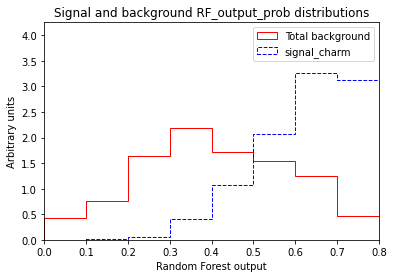

TypeError: unsupported operand type(s) for +: 'int' and 'str'

<Figure size 432x288 with 0 Axes>

In [421]:
RF_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Random Forest output', # x-axis label
}

SoverB_hist_dict = {'RF_output_prob':RF_output_prob}
plot_SoverB(df, SoverB_hist_dict)

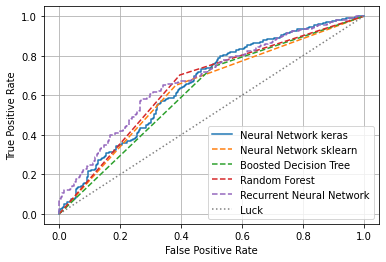

In [356]:
plt.plot(fpr_nn, tpr_nn, label='Neural Network keras') # plot random forest ROC
plt.plot(fpr_nn_sk, tpr_nn_sk, linestyle='dashed', label='Neural Network sklearn') # plot neural network ROC
plt.plot(fpr_bdt, tpr_bdt, linestyle='dashed', label='Boosted Decision Tree') # plot BDT ROC
plt.plot(fpr_rf, tpr_rf, linestyle='dashed', label='Random Forest') # plot RF ROC
plt.plot(fpr_rnn, tpr_rnn, linestyle='dashed', label='Recurrent Neural Network') # plot RNN ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend() # add a legend

In [357]:
df_all.head()

,jetNo,jetPTLeading,bjetPT,elecPTLeading,met,testnonTopMass,isSignal,dense_NN,sklearn_dense_NN,dense_RNN,dense_BDT_old,dense_BDT,dense_RF
entry,,,,,,,,,,,,,
0,2,181.824814,163.677521,88.220581,63.312572,475.149068,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,67.292442,32.879086,87.680885,32.989780,206.483257,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2,5,216.352081,48.157005,33.488476,145.810104,176.785610,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,4,347.645050,71.226440,65.760910,186.715225,172.066595,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,3,64.248962,80.717056,36.373375,61.273373,159.428297,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [365]:
# TP which is true signal predicted as signal
print(len(df_all[(df_all['isSignal'] == 1) & df_all['dense_NN']==1]))
print(len(df_all[(df_all['isSignal'] == 1) & df_all['sklearn_dense_NN']==1]))
print(len(df_all[(df_all['isSignal'] == 1) & df_all['dense_RNN']==1]))
print(len(df_all[(df_all['isSignal'] == 1) & df_all['dense_BDT_old']==1]))
print(len(df_all[(df_all['isSignal'] == 1) & df_all['dense_BDT']==1]))
print(len(df_all[(df_all['isSignal'] == 1) & df_all['dense_RF']==1]))
print(len(df_all[df_all['isSignal']==1]))

1131
1040
577
1376
1167
1273
1500


In [371]:
# FP which is true background predicted as signal
print(len(df_all[(df_all['isSignal'] == 0) & df_all['dense_NN']==1]))
print(len(df_all[(df_all['isSignal'] == 0) & df_all['sklearn_dense_NN']==1]))
print(len(df_all[(df_all['isSignal'] == 0) & df_all['dense_RNN']==1]))
print(len(df_all[(df_all['isSignal'] == 0) & df_all['dense_BDT_old']==1]))
print(len(df_all[(df_all['isSignal'] == 0) & df_all['dense_BDT']==1]))
print(len(df_all[(df_all['isSignal'] == 0) & df_all['dense_RF']==1]))
print(len(df_all[df_all['isSignal']==1]))

772
591
266
130
725
454
1500


In [374]:
#df_all[(df_all['isSignal'] == 1) & df_all['dense_BDT_old']==1][['isSignal', 'dense_BDT_old']].head(30)
#df_all[['isSignal', 'dense_BDT_old']].tail(30)

# Plot NN output vs input variables
Here, we will plot the NN output and devision boundary as a function of the input variables.

**Question 1:** How can we fill the correct numpy arrays for plotting?

In [7]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        #myZI[i,j] = ??? # change this

myZI = model.predict(np.c_[myXI.ravel(), myYI.ravel()])
myZI = myZI.reshape(myXI.shape)

(200, 200)


**Question 2:** The code below shows how to plot the NN output. How can we plot the NN decision boundary?

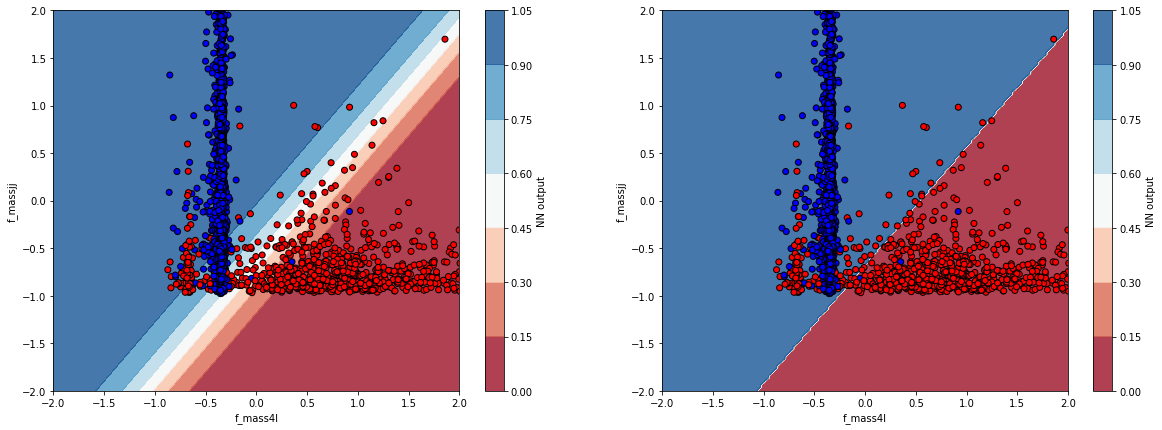

In [8]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points
ax = plt.subplot(1, 2, 2)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

**Question 3:** What happens if you increase/decrease the number of hidden layers?

**Question 4:** What happens if you increase/decrease the number of nodes per hidden layer?

**Question 5:** What happens if you add/remove dropout?

**Question 6:** What happens if you add/remove early stopping?

## Add prediction to `ROOT` trees
Here we'll add the precition we've computed to `ROOT` trees.

In [9]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_bkg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_bkg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

Welcome to JupyROOT 6.14/04
